In [85]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import statistics

# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()

df_covid19_cases_time= pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv")

C:\Users\Dima\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning:

Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.



In [86]:
yesterdays_date = (datetime.today() - timedelta(days=1)).strftime('%#m/%#d/%y')

In [87]:
input_country = "Ukraine"

In [88]:
european_countries_data = [
    {'Country': 'Austria', 'Close_Countries': ['Czechia','Slovakia','Slovenia','Hungary','Croatia', 'Liechtenstein', 'Germany']},
    {'Country': 'Belgium','Close_Countries': ['Netherlands', 'France', 'Luxembourg', 'Germany', 'Denmark']},
    {'Country': 'Czechia','Close_Countries': ['Slovakia','Poland','Hungary','Croatia', 'Austria', 'Germany']},
    {'Country': 'Denmark','Close_Countries': ['Sweden','Poland','Germany','Norway','Netherlands']},
    {'Country': 'Estonia','Close_Countries': ['Latvia','Lithuania','Sweden','Finland']},
    {'Country': 'Finland','Close_Countries': ['Latvia','Norway','Lithuania','Sweden','Estonia']},
    {'Country': 'France','Close_Countries': ['Spain','Italy','Germany','Belgium','Switzerland']},
    {'Country': 'Germany','Close_Countries': ['Poland','Czechia','Austria','Belgium','Switzerland','Netherlands']},
    {'Country': 'Hungary','Close_Countries': ['Slovakia','Czechia','Austria','Croatia', 'Ukraine']},
    {'Country': 'Italy','Close_Countries': ['Spain','France','Portugal','Croatia']},
    {'Country': 'Latvia','Close_Countries': ['Estonia','Lithuania','Belarus']},
    {'Country': 'Liechtenstein','Close_Countries': ['Switzerland','Luxembourg','Slovenia']},
    {'Country': 'Lithuania','Close_Countries': ['Estonia','Latvia','Belarus']},
    {'Country': 'Luxembourg','Close_Countries': ['Switzerland','Liechtenstein','Slovenia']},
    {'Country': 'Netherlands','Close_Countries': ['Belgium', 'France', 'Luxembourg', 'Germany', 'Denmark']},
    {'Country': 'Norway','Close_Countries': ['Sweden', 'Finland']},
    {'Country': 'Poland','Close_Countries': ['Germany','Czechia','Slovakia','Ukraine','Belarus']},
    {'Country': 'Portugal','Close_Countries': ['Spain','Italy']},
    {'Country': 'Slovakia','Close_Countries': ['Poland','Czechia','Austria','Hungary','Ukraine']},
    {'Country': 'Slovenia','Close_Countries': ['Switzerland','Liechtenstein','Croatia']},
    {'Country': 'Spain','Close_Countries': ['Portugal','Italy','France']},
    {'Country': 'Sweden','Close_Countries': ['Norway','Finland','Poland']},
    {'Country': 'Switzerland','Close_Countries': ['Liechtenstein','Luxembourg','Slovenia','Belgium','Austria']},
    {'Country': 'Ukraine',"Close_Countries": ["Belarus","Poland","Slovakia","Hungary","Romania"]},
    {'Country': 'Belarus','Close_Countries': ['Lithuania','Poland','Latvia','Ukraine']}
]

european_countries_data = pd.DataFrame(european_countries_data)

In [212]:
close_countries = european_countries_data[european_countries_data["Country"]==input_country]
close_countries = np.array(close_countries["Close_Countries"])[0]


close_countries_data = df_covid19_cases_time[df_covid19_cases_time["Country_Region"].isin(close_countries)]
close_countries_data = close_countries_data[close_countries_data["Last_Update"] == yesterdays_date].copy().drop(['Last_Update', 'Recovered', 'Active', 'Delta_Confirmed', 'Delta_Recovered', 'Incident_Rate', 'People_Tested', 'People_Hospitalized', 'Province_State', 'FIPS', 'UID', 'iso3', 'Report_Date_String'], axis=1)
close_countries_data.index = close_countries_data["Country_Region"]
close_countries_data = close_countries_data.drop(['Country_Region'], axis=1)

medical_rating = pd.read_csv("data/medical_system.csv")
medical_rating = medical_rating.copy().drop(['Health Distribution','Overall goal attainment', 'Health expenditure per capita in international dollars'],axis =1)
medical_rating.index = medical_rating["Country"]
medical_rating = medical_rating.drop(['Country'], axis=1)

merged_data = pd.merge(close_countries_data, medical_rating, left_index=True, right_index=True)

population = pd.read_csv("data/population_by_country.csv")
input_country_population = population[population["Country"] == input_country]["Population"]
population = population.copy().drop(['Yearly Change', 'Net Change', 'Density (P/Km²)', 'Land Area (Km²)', 'Migrants (net)', 'Fert. Rate', 'Med. Age', 'Urban Pop %', 'World Share'],axis=1)
population.index = population["Country"]
population = population.drop(['Country'], axis=1)

merged_data = pd.merge(merged_data, population, left_index=True, right_index=True)


not_actual_population_countries_index = merged_data[(merged_data['Population'] > int(input_country_population * 3.5)) | (merged_data['Population'] < int(input_country_population * 0.2))].index

merged_data.drop(not_actual_population_countries_index , inplace=True)

#
merged_data["coef"] = merged_data["Deaths"] /  ( merged_data["Confirmed"] * merged_data["Overall health system performance"])
top_2_countries_by_health_level = merged_data.sort_values("Health Level").head(2)

average_coef_by_most_healthy_counties = sum(top_2_countries_by_health_level["coef"]) / len(top_2_countries_by_health_level["coef"]) 

max_coef = max(merged_data["coef"])
min_coef = min(merged_data["coef"])


merged_data["Most likely deaths"] = average_coef_by_most_healthy_counties * merged_data["Confirmed"] * merged_data["Overall health system performance"]
merged_data["Min deaths (best-case scenario)"] = average_coef_by_most_healthy_counties * merged_data["Confirmed"] * merged_data["Overall health system performance"]
merged_data["Max deaths (Worst-case scenario)"] = max_coef * merged_data["Confirmed"] * merged_data["Overall health system performance"]

merged_data["Falsification %"] = (1 - merged_data["Deaths"] / merged_data["Most likely deaths"]) * 100
merged_data["best-case scenario falsification %"] = (1 - merged_data["Deaths"] / merged_data["Min deaths (best-case scenario)"]) * 100
merged_data["worst-case scenario falsification %"] = (1 - merged_data["Deaths"] / merged_data["Max deaths (Worst-case scenario)"]) * 100


# Just the country calculation
input_country_data = df_covid19_cases_time[df_covid19_cases_time["Country_Region"] == input_country]

input_country_data = input_country_data[input_country_data["Last_Update"] == yesterdays_date].copy().drop(['Last_Update', 'Recovered', 'Active', 'Delta_Confirmed', 'Delta_Recovered', 'Incident_Rate', 'People_Tested', 'People_Hospitalized', 'Province_State', 'FIPS', 'UID', 'iso3', 'Report_Date_String'], axis=1)
input_country_data.index = input_country_data["Country_Region"]
input_country_data = input_country_data.drop(['Country_Region'], axis=1)
input_country_data = pd.merge(input_country_data, medical_rating, left_index=True, right_index=True)


input_country_data["Most likely deaths"] = average_coef_by_most_healthy_counties * input_country_data["Confirmed"] * input_country_data["Overall health system performance"]
input_country_data["Min deaths (best-case scenario)"] = min_coef * input_country_data["Confirmed"] * input_country_data["Overall health system performance"]
input_country_data["Max deaths (Worst-case scenario)"] = max_coef * input_country_data["Confirmed"] * input_country_data["Overall health system performance"]

# general falsification
falsification = (1 - input_country_data["Deaths"] / input_country_data["Most likely deaths"]) * 100

if (float (falsification) < 0):
    falsification = 0
    
if (float (falsification) > 100):
    falsification = 100
    
input_country_data["Falsification %"] = falsification

# best case scenario falsification
best_case_scenario_falsification = (1 - input_country_data["Deaths"] / input_country_data["Min deaths (best-case scenario)"]) * 100

if (float (best_case_scenario_falsification) < 0):
    best_case_scenario_falsification = 0
    
input_country_data["best-case scenario falsification %"] = best_case_scenario_falsification

# worst case scenario falsification
worst_case_scenario_falsification = (1 - input_country_data["Deaths"] / input_country_data["Max deaths (Worst-case scenario)"]) * 100

if (float (worst_case_scenario_falsification) > 100):
    worst_case_scenario_falsification = 100

input_country_data["worst-case scenario falsification %"] = worst_case_scenario_falsification
merged_data


,Confirmed,Deaths,Delta_Deaths,Health Level,On level of health,Overall health system performance,Population,coef,Most likely deaths,Min deaths (best-case scenario),Max deaths (Worst-case scenario),Falsification %,best-case scenario falsification %,worst-case scenario falsification %
Belarus,111622,1033,6.0,83,116,72,9449940,0.000129,2477.964774,2477.964774,2661.834278,58.312563,58.312563,61.192175
Hungary,131887,2883,99.0,62,105,66,9665192,0.000331,2683.853199,2683.853199,2883.000000,-7.420182,-7.420182,0.000000
Poland,665547,9499,419.0,45,89,50,37854825,0.000285,10260.335610,10260.335610,11021.671221,7.420182,7.420182,13.815248
Romania,343725,8684,174.0,80,111,99,19262731,0.000255,10492.020906,10492.020906,11270.547988,17.232342,17.232342,22.949620


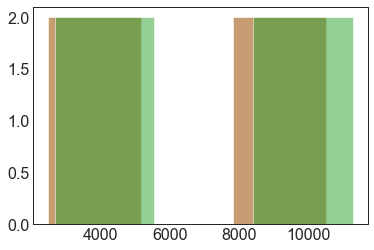

In [75]:
h1 = merged_data["Min deaths (best-case scenario)"]
h2 = merged_data["Most likely deaths"]
h3 = merged_data["Max deaths (Worst-case scenario)"]

kwargs = dict(bins=3, alpha=0.5)

plt.hist(h1, **kwargs)
plt.hist(h2, **kwargs)
plt.hist(h3, **kwargs)
plt.show()

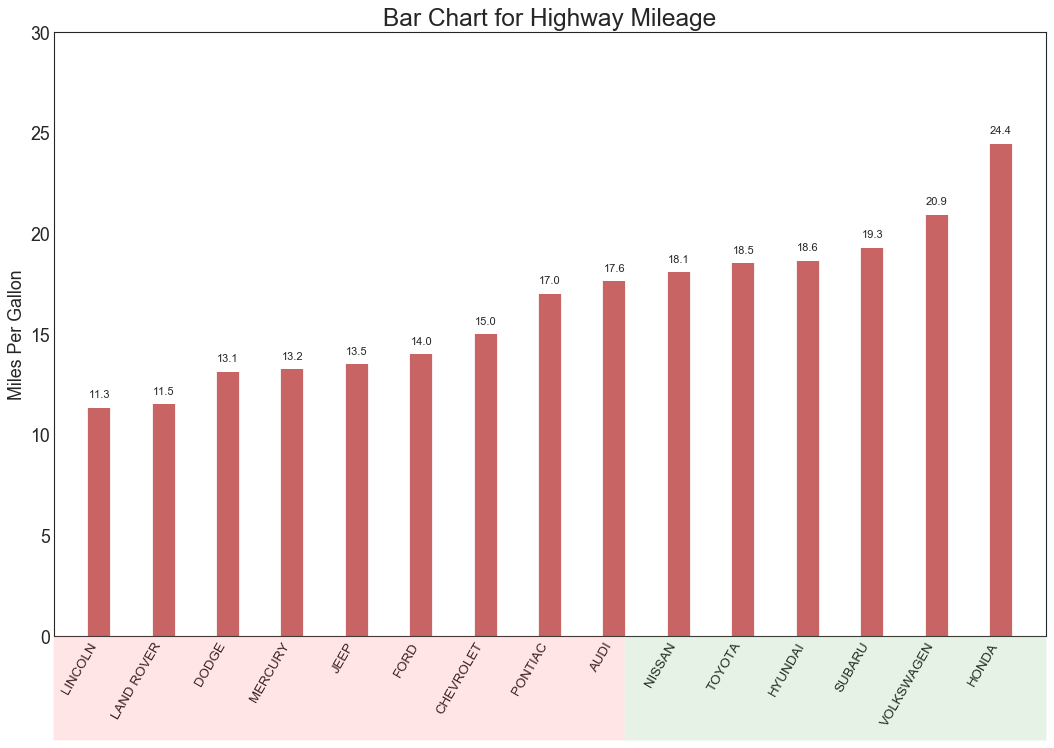

In [76]:
# Prepare Data
df_raw = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")
df = df_raw[['cty', 'manufacturer']].groupby('manufacturer').apply(lambda x: x.mean())
df.sort_values('cty', inplace=True)
df.reset_index(inplace=True)

# Draw plot
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
ax.vlines(x=df.index, ymin=0, ymax=df.cty, color='firebrick', alpha=0.7, linewidth=20)

# Annotate Text
for i, cty in enumerate(df.cty):
    ax.text(i, cty+0.5, round(cty, 1), horizontalalignment='center')


# Title, Label, Ticks and Ylim
ax.set_title('Bar Chart for Highway Mileage', fontdict={'size':22})
ax.set(ylabel='Miles Per Gallon', ylim=(0, 30))
plt.xticks(df.index, df.manufacturer.str.upper(), rotation=60, horizontalalignment='right', fontsize=12)

# Add patches to color the X axis labels
p1 = patches.Rectangle((.57, -0.005), width=.33, height=.13, alpha=.1, facecolor='green', transform=fig.transFigure)
p2 = patches.Rectangle((.124, -0.005), width=.446, height=.13, alpha=.1, facecolor='red', transform=fig.transFigure)
fig.add_artist(p1)
fig.add_artist(p2)
plt.show()

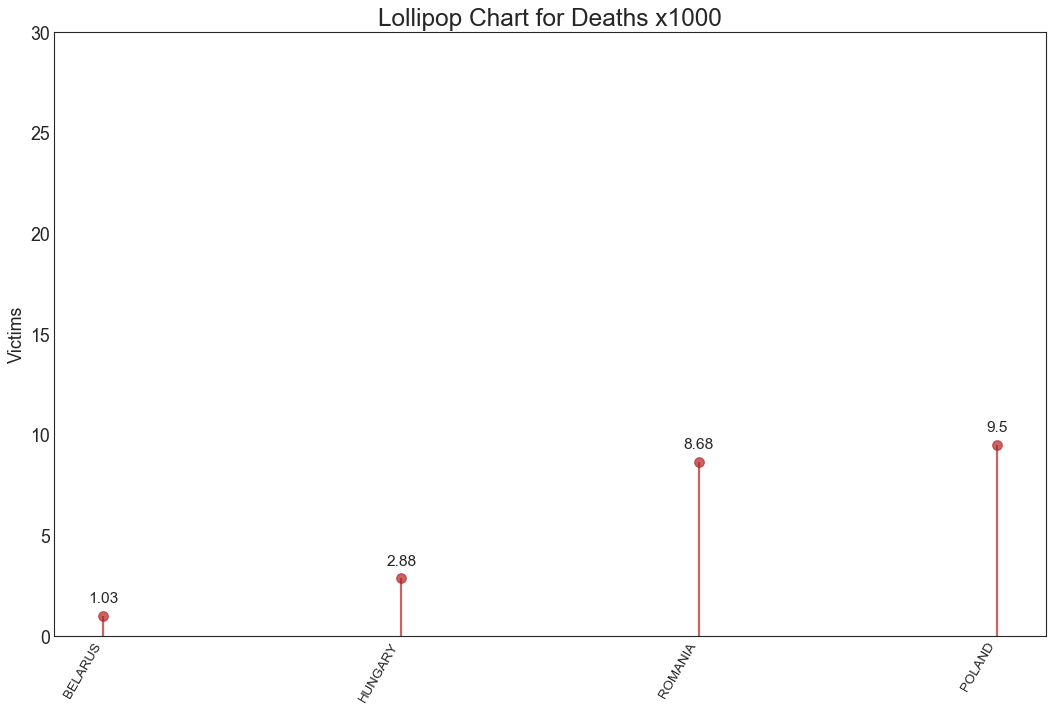

In [240]:
# Prepare Data
df = merged_data[['Deaths', 'Min deaths (best-case scenario)','Most likely deaths', 'Max deaths (Worst-case scenario)']]
df.sort_values('Deaths', inplace=True)
df.reset_index(inplace=True)

df['Deaths'] = df['Deaths'] / 1000 
df['Min'] = df['Min deaths (best-case scenario)'] / 1000 
df['Expected'] = df['Most likely deaths'] / 1000 
df['Max'] = df['Max deaths (Worst-case scenario)'] / 1000 

df["Country"] = df["index"]


# Draw plot official Deaths
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.vlines(x=df.index, ymin=0, ymax=df.Deaths, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=df.index, y=df.Deaths, s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Lollipop Chart for Deaths x1000', fontdict={'size':22})
ax.set_ylabel('Victims')
ax.set_xticks(df.index)
ax.set_xticklabels(df.Country.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 30)

# Annotate
for row in df.itertuples():
    ax.text(row.Index, row.Deaths+.5, s=round(row.Deaths, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

In [ ]:
# add parts of the country confirmed / died
# and than the average should be taken
# add functions for each operation
# add config in the beginning of the code
# make idenpendent code in seperate cells